<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/titanic_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!pip -q install keras_tuner

In [127]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv
!ls -al data
!wc -l data/*.csv

2025-03-30 23:22:46 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv [61194/61194] -> "data/titanic.csv" [1]
total 68
drwxr-xr-x 2 root root  4096 Mar 30 23:22 .
drwxr-xr-x 1 root root  4096 Mar 30 22:31 ..
-rw-r--r-- 1 root root 61194 Mar 30 23:22 titanic.csv
892 data/titanic.csv


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocess Data

See data dictionary in [https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/input]

In [129]:
df = pd.read_csv('./data/titanic.csv') #, index_col='PassengerId')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## drop columns

drop columns that are unique per record.

In [130]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

## deal with NaN fields

In [131]:
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687
Embarked,2


In [132]:
# Cabin has too many NaN records, drop it
df = df.drop(['Cabin'], axis=1)

A better way to fill in the NaN Age is to use average age per Pclass because there seem to have clear patterns of it.

<Axes: xlabel='Pclass', ylabel='Age'>

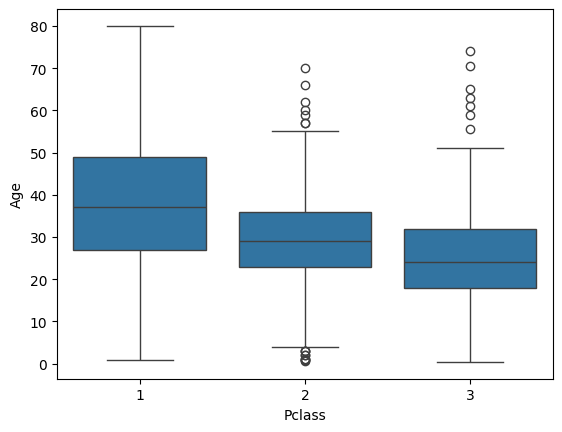

In [133]:
sns.boxplot(x='Pclass', y='Age', data=df)

In [134]:
fill_in_ages = df.groupby('Pclass')['Age'].mean()
fill_in_ages

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


In [135]:
fill_in_ages[fill_in_ages.index==1].values[0]

np.float64(38.233440860215055)

In [136]:
def fill_ages(x):
  if x.isna()['Age']: # x is Series, so we cannot use x['Age'].isna()
    x['Age'] = fill_in_ages[fill_in_ages.index==x['Pclass']].values[0]
    # print('replacing:', x['Age'])

  return x['Age']

In [137]:
# use median age for missing Age
# df['Age'] = df['Age'].fillna( df['Age'].median() )
df['Age'] = df.apply(fill_ages, axis=1)
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,2


In [138]:
# for the unknow embarked port, put U for unknown
df['Embarked'] = df['Embarked'].fillna('U')
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [139]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.00000,1,0,7.2500,S
1,1,1,female,38.00000,1,0,71.2833,C
2,1,3,female,26.00000,0,0,7.9250,S
3,1,1,female,35.00000,1,0,53.1000,S
4,0,3,male,35.00000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.00000,0,0,13.0000,S
887,1,1,female,19.00000,0,0,30.0000,S
888,0,3,female,25.14062,1,2,23.4500,S
889,1,1,male,26.00000,0,0,30.0000,C


## categorise data

        Survival Count  Mortality Count  Survaval Ratio %
Pclass                                                   
1                  136               80         62.962963
2                   87               97         47.282609
3                  119              372         24.236253


<Figure size 300x200 with 0 Axes>

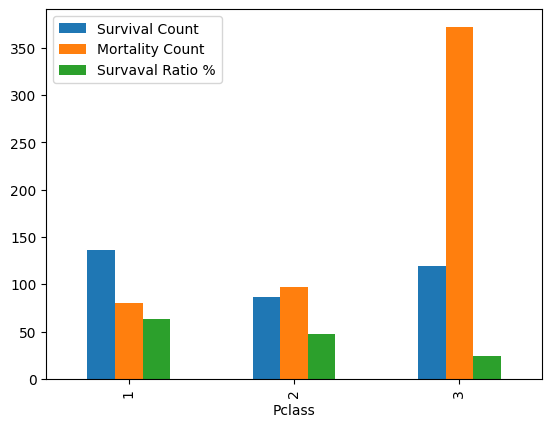

In [140]:
# Pclass

# calculate survival rate of each pclass:
pclass_survival_count = df.query('Survived == 1')['Pclass'].value_counts().sort_index()
pclass_mortal_count = df.query('Survived == 0')['Pclass'].value_counts().sort_index()
pclass_survival_ratio = pclass_survival_count / (pclass_survival_count + pclass_mortal_count) * 100

pclass_stats = pd.concat([pclass_survival_count, pclass_mortal_count, pclass_survival_ratio],
                         keys=['Survival Count', 'Mortality Count', 'Survaval Ratio %'], axis=1)
print(pclass_stats)

plt.figure(figsize=(3,2))
pclass_stats.plot(kind='bar')
plt.show()

By the look of the above, there seems to have some ordinality of Pclass on survival rate. So leave it as is.

In [141]:
# Sex only has 2 values, so turn them into 0 or 1
df['Sex'] = df['Sex'].astype('category').cat.codes
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.00000,1,0,7.2500,S
1,1,1,0,38.00000,1,0,71.2833,C
2,1,3,0,26.00000,0,0,7.9250,S
3,1,1,0,35.00000,1,0,53.1000,S
4,0,3,1,35.00000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,1,27.00000,0,0,13.0000,S
887,1,1,0,19.00000,0,0,30.0000,S
888,0,3,0,25.14062,1,2,23.4500,S
889,1,1,1,26.00000,0,0,30.0000,C


In [142]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked']

for var in categorical:
  df = pd.concat([df, pd.get_dummies(df[var], prefix=var, dtype='long')], axis=1)
  del df[var]

In [143]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,3,1,22.00000,1,0,7.2500,0,0,1,0
1,1,1,0,38.00000,1,0,71.2833,1,0,0,0
2,1,3,0,26.00000,0,0,7.9250,0,0,1,0
3,1,1,0,35.00000,1,0,53.1000,0,0,1,0
4,0,3,1,35.00000,0,0,8.0500,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.00000,0,0,13.0000,0,0,1,0
887,1,1,0,19.00000,0,0,30.0000,0,0,1,0
888,0,3,0,25.14062,1,2,23.4500,0,0,1,0
889,1,1,1,26.00000,0,0,30.0000,1,0,0,0


## scale continous columns

In [144]:
## scale continuous columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cont = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

for c in cont:
  df[c] = df[c].astype('float64')
  df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

In [145]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.0,-8.772133e-17,1.000562,-1.566107,-0.369365,0.827377,0.827377,0.827377
Sex,891.0,6.475870e-01,0.477990,0.000000,0.000000,1.000000,1.000000,1.000000
Age,891.0,9.968332e-17,1.000562,-2.186823,-0.552360,-0.249401,0.583736,3.840543
SibSp,891.0,4.386066e-17,1.000562,-0.474545,-0.474545,-0.474545,0.432793,6.784163
Parch,891.0,5.382900e-17,1.000562,-0.473674,-0.473674,-0.473674,-0.473674,6.974147
Fare,891.0,3.987333e-18,1.000562,-0.648422,-0.489148,-0.357391,-0.024246,9.667167
Embarked_C,891.0,1.885522e-01,0.391372,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,891.0,8.641975e-02,0.281141,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,891.0,7.227834e-01,0.447876,0.000000,0.000000,1.000000,1.000000,1.000000


In [146]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,0.827377,1,-0.552360,0.432793,-0.473674,-0.502445,0,0,1,0
1,1,-1.566107,0,0.659475,0.432793,-0.473674,0.786845,1,0,0,0
2,1,0.827377,0,-0.249401,-0.474545,-0.473674,-0.488854,0,0,1,0
3,1,-1.566107,0,0.432256,0.432793,-0.473674,0.420730,0,0,1,0
4,0,0.827377,1,0.432256,-0.474545,-0.473674,-0.486337,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,-0.369365,1,-0.173662,-0.474545,-0.473674,-0.386671,0,0,1,0
887,1,-1.566107,0,-0.779579,-0.474545,-0.473674,-0.044381,0,0,1,0
888,0,0.827377,0,-0.314491,0.432793,2.008933,-0.176263,0,0,1,0
889,1,-1.566107,1,-0.249401,-0.474545,-0.473674,-0.044381,1,0,0,0


In [147]:
df.to_csv('./data/preproc_data.csv', index=None)

## Split datasets

In [148]:
df = pd.read_csv('./data/preproc_data.csv')
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712,), (179,))

# Tensorflow model

In [150]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_tfmodel(units=[8, 32], optimizer='adam', activation='linear',
                  init='glorot_uniform', dr=0.0):
  """ units: list of hidden layer dimensions
    optim: optimisation method
    activation: activation functions 'linear', 'relu', etc.
    init: kernel initialiser of layer
    dr: dropout rate
  """
  model = Sequential()
  # input layer
  model.add(Dense(units[0], input_dim=X_train.shape[1],
                  activation=activation, kernel_initializer=init))

  # hidden layers
  for dim in units[1:]:
    model.add(Dense(dim), activation=activation, kernel_initializer=init)

  model.add(Dropout(dr))

  # output layer
  model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model


In [151]:
tf_model = build_tfmodel(units=[8], activation='relu')
tf_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [152]:
tf_train_result = tf_model.fit(X_train, y_train, batch_size=16, epochs=100,
                        validation_split=0.2, verbose=0)

acc = np.mean(tf_train_result.history['accuracy'])
loss = np.mean(tf_train_result.history['loss'])
val_acc = np.mean(tf_train_result.history['val_accuracy'])
val_loss = np.mean(tf_train_result.history['val_loss'])
print(f"  training accuracy: {acc:.4f}, loss: {loss:.4f}")
print(f"validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")

  training accuracy: 0.7984, loss: 0.4511
validation accuracy: 0.8122, loss: 0.4359


In [153]:
tf_train_result.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

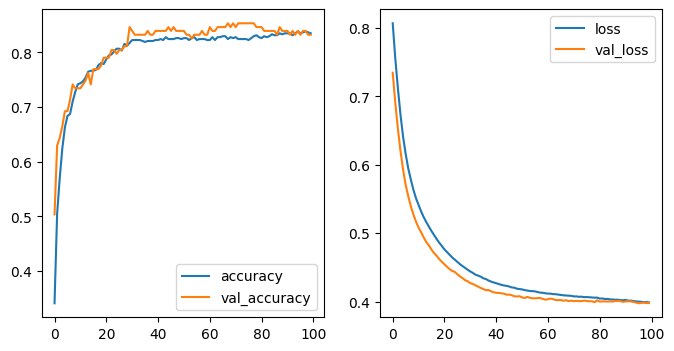

In [154]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(tf_train_result.history['accuracy'])
ax1.plot(tf_train_result.history['val_accuracy'])
ax1.legend(['accuracy', 'val_accuracy'])

ax2.plot(tf_train_result.history['loss'])
ax2.plot(tf_train_result.history['val_loss'])
ax2.legend(['loss', 'val_loss'])

plt.show()

In [155]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_U'],
      dtype='object')

In [156]:
input_weights = tf_model.get_layer('dense').get_weights()[0]
input_weights.sum(axis=1)

ValueError: No such layer: dense. Existing layers are: ['dense_2', 'dropout_1', 'dense_3'].

In [ ]:
# show weights
plt.figure(figsize=(4,3))
plt.imshow(input_weights)
plt.colorbar()
plt.show()

looking at columns 0 and 5 of above heatmap, the 2nd feature (Sex) has high weight, which makes sense: females survived more. Last feature is embark_U which has very low weight - it does not matter to survival.

In [ ]:
X.columns[input_weights[:,0].argsort()[::-1]]

In [ ]:
X.columns[input_weights[:,6].argsort()]

In [ ]:
X.columns[input_weights.sum(axis=1).argsort()[::-1]]

## Using Keras Tuner
[https://keras.io/keras_tuner/getting_started/]

In [ ]:
import keras_tuner

def build_ktmodel(hp):
  """ keras_tuner
  """
  init = hp.Choice("init", ['glorot_uniform', 'normal', 'uniform'])
  model = Sequential()
  # input layer
  model.add(Dense(units=hp.Int("units", min_value=8, max_value=64, step=16),
                  input_dim=X_train.shape[1],
                  activation=hp.Choice("activation", ["linear", "relu", "tanh"]),
                  kernel_initializer=init
                  )
            )
  model.add(Dropout(hp.Float("dr", min_value=0.0, max_value=0.5, step=0.1)))

  # hidden layers
  # for dim in units[1:]:
  #   model.add(Dense(dim), activation=activation, kernel_initializer=init)

  # model.add(Dropout(dr))

  # output layer
  model.add(Dense(1, activation='sigmoid',
                  kernel_initializer=init))

  model.compile(loss='binary_crossentropy',
                optimizer=hp.Choice("optimizer", ['adam', 'rmsprop']),
                metrics=['accuracy'])

  return model

# build_ktmodel(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_ktmodel,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
input_weights = best_model.get_layer('dense').get_weights()[0]
input_weights.sum(axis=1)

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(input_weights)
plt.colorbar()
plt.show

the plot clearly shows that the 2nd feature (Sex) is significant, followed by Pclass and Age.

In [ ]:
X.columns

In [ ]:
X.columns[input_weights[:,0].argsort()[::-1]]

In [ ]:
X.columns[input_weights.sum(axis=1).argsort()[::-1]]

# PyTorch model

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim

class PtModel(nn.Module):
  def __init__(self, units=[8, 32], activation=nn.ReLU, dr=0.0):
    super().__init__()
    model = nn.Sequential()
    # input layer
    model.add_module('input layer', Linear(X_train.shape[1], units[0]))
    model.add_module('act', activation())
    model.add_module('dropout', nn.Dropout(p=dr))

    # hidden layers
    for i in range(1, len(units)-1):
      model.add_module(f'hidden layer {i}', Linear(units[i-1], units[i]))
      model.add_module(f'activation {i}', activation())
      model.add_module(f'dropout {i}', nn.Dropout(p=dr))

    # output layer
    model.add_module('output layer', Linear(units[-1], 1))
    model.add_module('sigmoid', nn.Sigmoid())

    self.model = model

  def forward(self, x):
    return self.model(x)


In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs):
  model.train()

  losses = []
  for epoch in range(epochs):
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
      optimizer.zero_grad()
      preds = model(X_batch).squeeze()
      loss = criterion(preds, y_batch.float())
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      # print(f'epoch {epoch}: loss={loss.item()}')


    losses.append(running_loss)
    if(epoch % 10 == 0):
      print(f'Epoch {epoch}/{epochs}: training batch avg loss = {running_loss / len(train_loader)}')

  print(f'Epoch {epoch}/{epochs}: training batch avg loss = {running_loss / len(train_loader)}')
  return losses

def evalulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      preds = (model(X_batch).squeeze() > 0.5).float()
      correct += (preds==y_batch.float()).sum().item()
      total += y_batch.size(0)

  accuracy = correct / total * 100
  print(f'Test accuracy = {accuracy} %')

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

epochs = 100
batch_size = 16
lr = 1e-3
pt_model = PtModel(units=[8])

X_train_tensors = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train.values, dtype=torch.int32)
X_test_tensors = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test.values, dtype=torch.int32)
train_loader = DataLoader(TensorDataset(X_train_tensors, y_train_tensors), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(pt_model.parameters(), lr=lr)
losses = train_model(pt_model, train_loader,
                     criterion, optimiser, epochs=epochs)

In [ ]:
plt.scatter(range(epochs), [l/y_train.shape[0] for l in losses])

In [ ]:
evalulate_model(pt_model, test_loader)

In [ ]:
diff = pd.DataFrame({
    'preds': (pt_model(X_test_tensors).squeeze() > 0.5).numpy().astype(np.long),
    'labels': y_test_tensors.numpy().astype(np.long),
})
sum(abs(diff['preds']-diff['labels']))
# plt.scatter(len(diff), diff['preds']-diff['labels'])

In [ ]:
input_weights = pt_model.model[0].weight.data.detach().numpy()
plt.figure(figsize=(4,3))
plt.imshow(input_weights)
plt.colorbar()
plt.show()

this looks more consistent than the keras plot. It is obvious 2nd feature (Sex) is most prominent, followed by 3rd (Age).

In [ ]:
X.columns[input_weights.sum(axis=0).argsort()[::-1]]

In [ ]:
X.columns

# check features survival rate

In [ ]:
df = pd.read_csv('./data/titanic.csv')
df['Age'] = df['Age'].fillna( df['Age'].median() )
df['Embarked'] = df['Embarked'].fillna('U')
df

In [ ]:
def col_stat(col):
  survival_count = df.query('Survived == 1')[col].value_counts().sort_index()
  mortal_count = df.query('Survived == 0')[col].value_counts().sort_index()
  survival_ratio = survival_count / (survival_count + mortal_count) * 100

  stats = pd.concat([survival_count, mortal_count, survival_ratio],
                          keys=['Survival Count', 'Mortality Count', 'Survaval Ratio %'], axis=1)
  stats = stats.fillna(0)
  print(stats)

  fig, (ax) = plt.subplots(1,1, figsize=(5,3))
  stats.plot(kind='bar', ax=ax)
  ax.set_xticklabels(stats.index, rotation=45)
  plt.show()
  return stats

In [ ]:
stats = col_stat('Sex')

In [ ]:
stats = col_stat('Age')

In [ ]:
stats = col_stat('Embarked')

In [ ]:
stats = col_stat('SibSp')

In [ ]:
stats = col_stat('Parch')

In [ ]:
stats = col_stat('Fare')